# Vectorization Methods and Classification

In the previous notebook (`1-Text-Preprocessing`), we've created a text pre-processing pipeline.

Here, we're going to apply the `TF-IDF` and `Word2Vec` vectorization methods to our preprocessed data and test it on some supervised machine learning algorithms.


### Importing Libraries

In [1]:
import zipfile
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from utils import text_preprocessing, evaluate_model

# seaborn config
sns.set(font_scale=1.2)
sns.set_palette("pastel")

# Defining some colors
gray = "#9E9E9E"
blue = "#4285F4"

### Loading Data

In [2]:
# Reading the zipfile containing the datasets
zf = zipfile.ZipFile("data/olist-datasets.zip")

# Loading the order reviews dataset
reviews_df = pd.read_csv(zf.open("olist_order_reviews_dataset.csv"),
                         parse_dates=['review_creation_date', 
                                      'review_answer_timestamp'])

# Removing Orders without a written review
reviews_df = (reviews_df[['review_comment_message', 'review_score']]
              .dropna(subset=["review_comment_message"])).reset_index(drop=True)
print(f"> We have {len(reviews_df)} written reviews.")
reviews_df.head()

> We have 40977 written reviews.


,review_comment_message,review_score
0,Recebi bem antes do prazo estipulado.,5
1,Parabéns lojas lannister adorei comprar pela I...,5
2,aparelho eficiente. no site a marca do aparelh...,4
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4
4,"Vendedor confiável, produto ok e entrega antes...",5


## 1. Creating our target
___

As we mentioned before, we are going to be working with **supervisioned machine learning algorithms** and try to predict the review score. But, as we saw in our EDA (`0-Exploratory-Data-Analysis.ipynb`), the score distribution is highly imbalanced in 5 different categories (1, 2, 3, 4 and 5).

So, instead of working with multiple classes we'll transform our problem into a binary classification problem.

We are going to split the written reviews as follows:
- **[1]** Positive Reviews: review_score > 3
- **[0]** Negative Reviews: review_score <= 3


In [3]:
reviews_df["positive_review"] = (reviews_df['review_score']
                                 .apply(lambda x: 1 if x>3 else 0))
reviews_df.sample(5)

,review_comment_message,review_score,positive_review
7246,"A película não encaixa, não possui o formato d...",2,0
38499,Boa noite\r\nRecebi duas das três luminárias q...,1,0
18819,COMO FAÇO PRA FAZER A TROCA ..PRODUTO ERRADO,4,1
898,Chegou dentro do prazo.,4,1
1386,"Não posso avaliar, não sei oque houve !",1,0


- **Target distribution:**

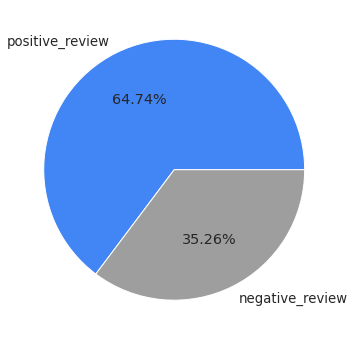

In [4]:
target_count = (reviews_df['positive_review']
                .value_counts()
                .rename({1: "positive_review",
                     0: "negative_review"}))

# Pie Chart
plt.figure(figsize=(14,6))
plt.pie(target_count, 
        labels = target_count.index,
        colors = [blue, gray],
        autopct='%.2f%%')
plt.show()

## 2. Preprocessing Data
___

First, let's run the preprocessing pipeline on our data:

In [5]:
# Loading the portuguese stopwords and nltk stemmer
stopwords_ptbr = nltk.corpus.stopwords.words("portuguese")
nltk_stemmer = nltk.RSLPStemmer()

# Running our preprocessing pipeline
reviews_df['preprocessed_review'] = [text_preprocessing(text, stopwords_ptbr, nltk_stemmer)
                                     for text in reviews_df['review_comment_message']]

In [6]:
reviews_df.sample(5)

,review_comment_message,review_score,positive_review,preprocessed_review
36069,O produto não é igual a foto e a entrega não f...,3,0,produt negaca igual fot entreg negaca feit con...
40400,VENDEDOR CONFIÁVEL,5,1,vend confia
31537,Entregou corretamente,5,1,entreg corret
26336,Recebi o produto muito bem embalado e de ótima...,5,1,receb produt bem embal otim qual recom
22229,Não recebi o produto,2,0,negaca receb produt


## 3. TF-IDF
___

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

- **Extracting Features using TF-IDF:**

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=300)
tfidf_features = tfidf_vectorizer.fit_transform(reviews_df['preprocessed_review'])

Let's see how TF-IDF has represented our data:

In [8]:
pd.DataFrame(tfidf_features.todense(),
             columns=tfidf_vectorizer.get_feature_names_out())

,abr,acab,ach,acontec,acord,ador,adquir,agil,agor,aguard,...,val,vc,vei,vem,vend,ver,vez,vier,volt,vou
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.306756,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.19599,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.592227,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.454531,0.0,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40972,0.0,0.0,0.0,0.0,0.628539,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
40973,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
40974,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.290627,...,0.000000,0.0,0.0,0.0,0.300903,0.0,0.00000,0.0,0.0,0.0
40975,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0


- **Splitting into training, validation and testing:**

In [9]:
# Splitting the data in training and remaining
X_train, X_rem, y_train, y_rem = train_test_split(tfidf_features,
                                                    reviews_df['positive_review'],
                                                    random_state=42,
                                                    train_size=0.8)

# Splitting the remaining data in validation and testing (50% each)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

print(f"> {X_train.shape[0]} samples for training")
print(f"> {X_valid.shape[0]} samples for validation")
print(f"> {X_test.shape[0]} samples for testing")

> 32781 samples for training
> 4098 samples for validation
> 4098 samples for testing


- **Model Evaluation:**

Let's see how well the `LogisticRegression`, `RandomForest` and `XGBoost` models are able to predict the target.

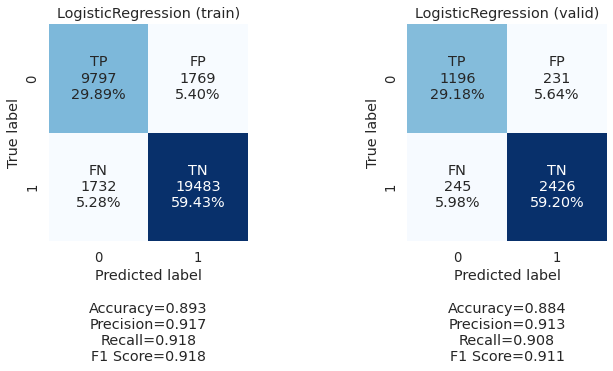

In [15]:
lr = LogisticRegression(random_state=42)
evaluate_model(lr, X_train, y_train, X_valid, y_valid, figsize=(10, 4), percentages=True)

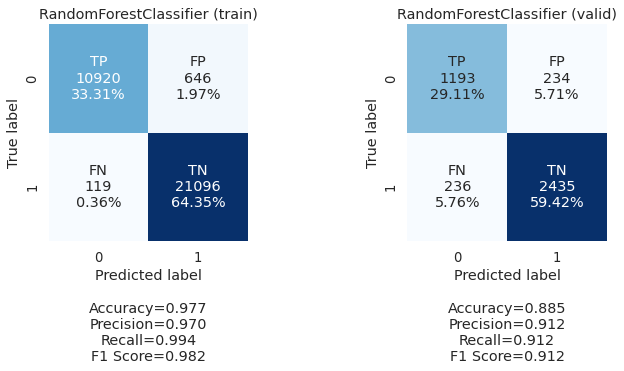

In [13]:
rf = RandomForestClassifier(random_state=42)
evaluate_model(rf, X_train, y_train, X_valid, y_valid, figsize=(10, 4), percentages=True)

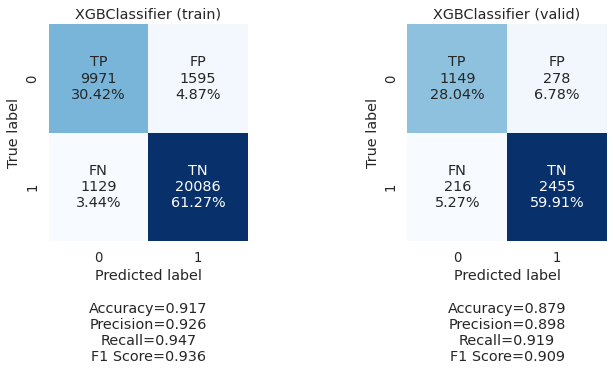

In [14]:
xgb = XGBClassifier(verbosity=0, use_label_encoder=False, random_state=42)
evaluate_model(xgb, X_train, y_train, X_valid, y_valid, figsize=(10, 4), percentages=True)